###INSTALLING AND IMPORTING DEPENDECIES

In [43]:
!pip install psutil
!pip install shap
!pip install tensorflow
!pip install tensorflow-model-analysis
!pip install shap
!pip install lime
!pip install imbalanced-learn

In [141]:
import numpy as np
import shap
import torch
import psutil
import time
import sys
import pickle
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow_model_analysis.addons.fairness.post_export_metrics import fairness_indicators
from tensorflow_model_analysis.addons.fairness.view import widget_view
#from tensorflow_model_analysis.addons.fairness.view import slicing_metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix
#from imblearn.metrics import classification_report_imbalanced, confusion_matrix
from sklearn.metrics import mean_absolute_error
from transformers import BertTokenizer, BertModel, GPT2LMHeadModel, GPT2Tokenizer
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

###1. Performance Evaluation

In [85]:
def performance_evaluation(model, X_test, y_test, isClassification = True):
    """
    Perform comprehensive performance evaluation for a given machine learning model.

    Parameters:
    - model: Trained machine learning model.
    - X_test: Test features.
    - y_test: Test labels.

    Returns:
    - None (prints evaluation metrics).
    """
    def print_classification_metrics(y_true, y_pred, pred_proba):
        print("\nClassification Metrics:")
        #print(y_true)
        #print(y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        cmatrix = confusion_matrix(y_true, y_pred)
        TP = cmatrix[1, 1]
        FP = cmatrix[0, 1]
        FN = cmatrix[1, 0]
        TN = cmatrix[0, 0]
        fpr = FP / (FP + TN)
        fnr = FN / (TP + FN)
        tpr = TP / (TP + FN)
        tnr = TN / (FP + TN)

        y_true_tensor = torch.LongTensor(y_true.values)  # Convert to PyTorch tensor
        pred_proba_tensor = torch.Tensor(pred_proba)

        loss = nn.CrossEntropyLoss()
        cross_entropy_loss = loss(pred_proba_tensor, y_true_tensor)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC: {roc_auc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"True Positive Rate: {tpr:.4f}")
        print(f"True Negative Rate: {tnr:.4f}")
        print(f"False Positive Rate: {fpr:.4f}")
        print(f"False Negative Rate: {fnr:.4f}")
        print(f"Cross entropy loss: {cross_entropy_loss:.4f}")
        print("\nConfusion Matrix:")
        print(cmatrix)

    def print_regression_metrics(y_true, y_pred):
        print("\nRegression Metrics:")
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mbd = np.mean(y_true) - np.mean(y_pred)
        r2 = r2_score(y_true, y_pred)

        print(f"MAE: {mae:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"Mean Bias Deviation: {mbd:.4f}")
        print(f"R-Squared: {r2:.4f}")

    print("\nTest Set Evaluation:")
    test_predictions = model.predict(X_test)
    if isClassification:  # Classification with probability estimates
        test_predictions = model.predict(X_test)
        test_predictions_proba = model.predict_proba(X_test)
        print_classification_metrics(y_test, test_predictions, test_predictions_proba)
    else:  # Classification or Regression without probability estimates
        test_predictions = model.predict(X_test)
        print_regression_metrics(y_test, test_predictions)

###2. Inference Time and Environmental Impact

In [33]:
def inference_time_and_environmental_impact_evaluation(model, X_test):
    """
    Perform inference time and environmental impact evaluation for a given machine learning model.

    Parameters:
    - model: Trained machine learning model.
    - X_test: Test features.

    Returns:
    - None (prints evaluation metrics).
    """

    def estimate_model_size(model):
        model_size = sys.getsizeof(pickle.dumps(model))

        model_size_gb = model_size / (1024**3)

        return model_size_gb

    def evaluate_model_efficiency(model, X_test):
        carbon_emission_factor = 0.865  # kgCO2/kwHr
        hardware_power_consumption = 0.06  # kw
        i = 0
        inference_times = []
        for _ in range(len(X_test)):
            start_time = time.time()
            _ = model.predict(X_test[:1])
            end_time = time.time()
            inference_times.append(end_time - start_time)
            i+=1

        average_inference_time = sum(inference_times) / len(inference_times)
        co2_emission_per_prediction = carbon_emission_factor * hardware_power_consumption * average_inference_time
        co2_emission_total = co2_emission_per_prediction*i
        model_size_gb = estimate_model_size(model)

        summary_paragraph = (
            f"Our platform evaluates the model's inference time and environmental impact. "
            f"\nThe average time taken to make an inference is measured and converted to CO2 emissions, assuming "
            f"\nCoal as a fuel for energy generation and Xeon 2.2 GHz Core. The mass of emitted CO2 by a single prediction is "
            f"\nestimated to be approximately {co2_emission_per_prediction:.4f} kgCO2. The estimated model storage size is {model_size_gb:.4f} GB."
        )
        return average_inference_time, co2_emission_per_prediction, co2_emission_total, model_size_gb, summary_paragraph


    ait, co2_per, co2_total, msize, sp = evaluate_model_efficiency(model, X_test)
    print(f"Average Inference Time: {ait:.4f} seconds")
    print(f"CO2 Emission per Prediction: {co2_per:.4f} kgCO2")
    print(f"CO2 Emission in total: {co2_total:.4f} kgCO2")
    print(f"Estimated Model Storage Size: {msize:.4f} GB")
    print("\n"+sp + "\n")

###3. Model Bias and Variance Analysis

In [211]:
def model_bias_and_variance_analysis(model, X_test, y_test):
    # Measure the bias in the dataset
    X_test = pd.DataFrame(X_test)
    feature_null_values_dict = {}
    for feature_name in X_test.columns:
        feature_null_values = np.count_nonzero(X_test[feature_name].isnull())
        feature_null_percentage = feature_null_values / len(X_test)
        feature_null_values_dict[feature_name] = feature_null_percentage
    # Evaluate the average absolute performance difference among the subsets of the testing after splitting based on the unique values of categorical features.
    category_bias_list = []
    for category in X_test.columns[X_test.dtypes == 'float64']:
        category_values = X_test[category].unique()
        category_bias = 0
        #print(category_values)
        for category_value in category_values:
          category_subset = X_test[X_test[category] == category_value]
          perturbed_predictions = model.predict(category_subset)
          perturbed_accuracy = accuracy_score(perturbed_predictions, y_test[:len(perturbed_predictions)])  # Adjusted here
          category_bias += abs(perturbed_accuracy - accuracy_score(y_test, model.predict(X_test))) / len(category_values)
        category_bias_list.append(category_bias)


    # Measure the variance in the dataset
    feature_perturbation_list = []
    for feature_name in X_test.select_dtypes(include='number').columns:
        feature_values = X_test[feature_name].values
        sorted_feature_values = sorted(feature_values)
        feature_perturbation = 0
        for i in range(len(feature_values)):
            perturbed_feature_values = feature_values.copy()
            perturbed_feature_values[i] = sorted_feature_values[(i + 1) // 2]
            perturbed_X_test = X_test.copy()
            perturbed_X_test.loc[:, feature_name] = perturbed_feature_values
            perturbed_predictions = model.predict(perturbed_X_test)
            perturbed_accuracy = accuracy_score(perturbed_predictions, y_test[:len(perturbed_predictions)])  # Adjusted here
            feature_perturbation += abs(perturbed_accuracy - accuracy_score(y_test, model.predict(X_test)))
        feature_perturbation_list.append(feature_perturbation)

    print("Feature Null Values:", feature_null_values_dict)
    print("Category Bias List:", category_bias_list)
    print("Feature Perturbation List:", feature_perturbation_list)

###4. Ethical Input Feature Analysis

In [203]:
def ethical_input_feature_analysis(model_data, X_test, model_name="prajjwal1/bert-mini"):
    def get_shap_value(model, X_test):
      explainer = shap.Explainer(model)
      shap_values = explainer.shap_values(X_test)
      shap.summary_plot(shap_values, X_test)


    def analyze_ethical_concerns(cls_embedding):
        unethical_features = ["Gender", "Race", "Nationality", "Religion",
                              "Sexual orientation", "Age", "Disability",
                              "Socioeconomic status", "Education level",
                              "Marital status", "Ethnicity", "Genetic information",
                              "Political affiliation", "Immigration status",
                              "Health status", "Military status", "Indigenous identity",
                              "Language", "Family status", "Veteran status"]
        unethical_word_embeddings = []
        for word in unethical_features:
            word_tokens = tokenizer.encode(word, add_special_tokens=True)
            word_input_ids = torch.tensor(word_tokens).unsqueeze(0)

            # Use no_grad to disable gradient computation
            with torch.no_grad():
                word_outputs = model(word_input_ids)
                word_cls_embedding = word_outputs.last_hidden_state[:, 0, :]

            unethical_word_embeddings.append(word_cls_embedding.detach().numpy())

        similarities = [cosine_similarity(cls_embedding.detach().numpy(), gender_embedding) for gender_embedding in unethical_word_embeddings]

        is_biased = sum(similarities) > 15

        return is_biased
    # Load the BERT model and tokenizer
    model = BertModel.from_pretrained(model_name)
    tokenizer = BertTokenizer.from_pretrained(model_name)

    ethical_analysis_results = []

    try:
        X_test = pd.DataFrame(X_test)
        feature_descriptions = X_test.columns
    except:
        pass

    for feature_description in feature_descriptions:
        # Tokenize the feature description
        tokens = tokenizer.encode(feature_description, add_special_tokens=True)

        # Convert the tokens to PyTorch tensors
        input_ids = torch.tensor(tokens).unsqueeze(0)

        # Forward pass through the BERT model
        outputs = model(input_ids)

        # Extract the output embeddings for the [CLS] token (first token)
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        ethical_result = analyze_ethical_concerns(cls_embedding)

        # Append the analysis result for the current feature to the results list
        ethical_analysis_results.append({
            'feature_description': feature_description,
            'is_unethical': ethical_result
        })
    print(ethical_analysis_results)
    get_shap_value(model_data, X_test)
    # Return the list of ethical analysis results for each feature
    return ethical_analysis_results



#THE PIPELINE

In [196]:
def pipeline(model, X_test, y_test, X_test_non, feature_descriptions, isClassification):
  model = pickle.load(open(model, 'rb'))
  performance_evaluation(model, X_test, y_test, isClassification)
  inference_time_and_environmental_impact_evaluation(model, X_test)
  ethical_input_feature_analysis(model, X_test_non)
  model_bias_and_variance_analysis(model, X_test, y_test)


#Testing on titanic dataset

In [184]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [185]:
train = pd.read_csv('/content/drive/MyDrive/Carrera/4.maila_erasmus/Explainable/Second_project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Carrera/4.maila_erasmus/Explainable/Second_project/test.csv')

In [186]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [187]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [191]:
from sklearn.preprocessing import LabelEncoder
X = train.drop(['Survived', 'Name'], axis=1)  # Features
y = train['Survived']  # Target variable
X_encoded = X.copy()
label_encoder = LabelEncoder()
for column in X.columns:
    X_encoded[column] = label_encoder.fit_transform(X[column])
X = X_encoded
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


imputer = SimpleImputer(strategy='median')  # You can adjust the strategy based on your needs
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train_imputed, y_train)

# Make predictions on the validation set
predictions = rf_model.predict(X_val_imputed)

# Evaluate the accuracy
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.84



Test Set Evaluation:

Classification Metrics:
Accuracy: 0.8380
AUC: 0.8220
F1 Score: 0.7883
True Positive Rate: 0.7297
True Negative Rate: 0.9143
False Positive Rate: 0.0857
False Negative Rate: 0.2703
Cross entropy loss: 0.5043

Confusion Matrix:
[[96  9]
 [20 54]]
Average Inference Time: 0.0090 seconds
CO2 Emission per Prediction: 0.0005 kgCO2
CO2 Emission in total: 0.0833 kgCO2
Estimated Model Storage Size: 0.0016 GB

Our platform evaluates the model's inference time and environmental impact. 
The average time taken to make an inference is measured and converted to CO2 emissions, assuming 
Coal as a fuel for energy generation and Xeon 2.2 GHz Core. The mass of emitted CO2 by a single prediction is 
estimated to be approximately 0.0005 kgCO2. The estimated model storage size is 0.0016 GB.

[{'feature_description': 'PassengerId', 'is_unethical': array([[False]])}, {'feature_description': 'Pclass', 'is_unethical': array([[ True]])}, {'feature_description': 'Sex', 'is_unethical': array

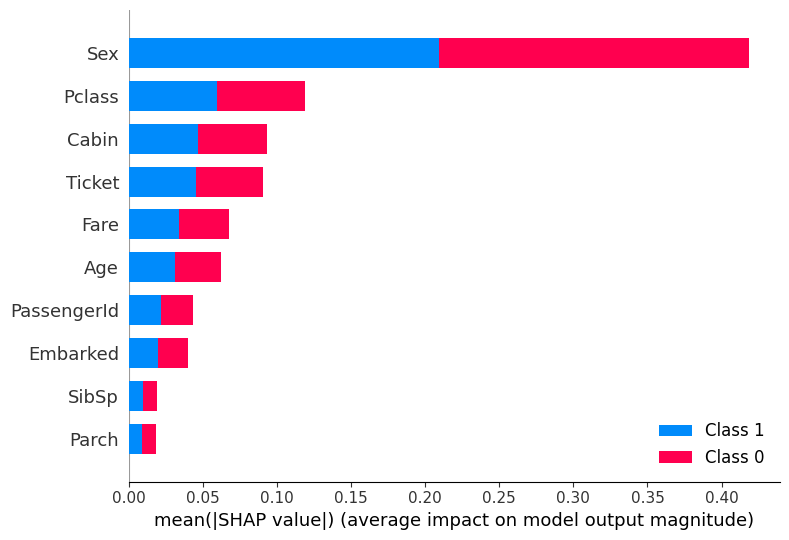

Feature Null Values: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
Category Bias List: [0.6000749040292133, 0.3502569738981535, 0.3632193933505568, 0.4544741616485221, 0.3341537013676138, 0.4040682765629754, 0.5952585589457091, 0.47116608612849414, 0.40339907581748263, 0.2975028649890514]
Feature Perturbation List: [0.050279329608938994, 0.07821229050279399, 0.32960893854748896, 0.07821229050279399, 0.005586592178770999, 0.011173184357541999, 0.08938547486033599, 0.050279329608938994, 0.08379888268156499, 0.039106145251396995]


In [212]:
pickle.dump(rf_model, open('model.pkl', 'wb'))

pipeline('model.pkl', X_test=X_val_imputed, X_test_non = X_val, feature_descriptions="", y_test=y_val, isClassification = True)